In [37]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [38]:
inputs = np.load("features.npy")
classes = np.load("classes.npy")

In [39]:
def display_img(img, label):
    # print(f"Label : {dataset.classes[label]}")
    # Assuming your images are 100x150 pixels and RGB
    height = 100
    width = 150
    channels = 3

    # Reshape the image
    img_3d = img.view(height, width, channels)

    # Permute the dimensions to (channels, height, width)
    img_3d = img_3d.permute(2, 0, 1)

    # Permute the dimensions to (height, width, channels)
    img_3d = img_3d.permute(1, 2, 0)

    # Display the image
    plt.imshow(img_3d)

torch.Size([547, 45000])
torch.Size([547])
tensor([190, 191, 209,  ..., 106, 135, 165], dtype=torch.uint8)
tensor(1, dtype=torch.int32)


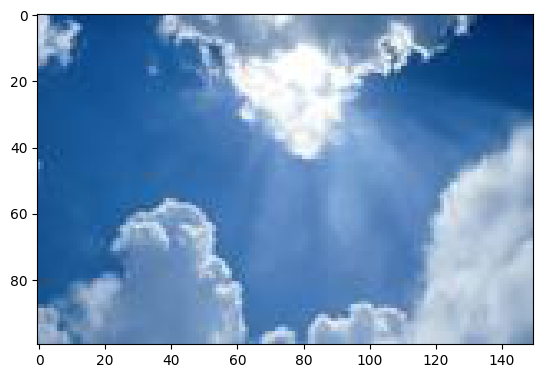

In [40]:
images = torch.tensor(inputs)
labels = torch.tensor(classes.copy())
print(images.shape)
print(labels.shape)

dataset = TensorDataset(images, labels)
# Assuming you have already loaded your dataset
total_samples = len(dataset)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size
batch_size = 128

train_subset, val_subset, test_subset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Get the data points and labels in each subset
X_train, y_train = zip(*[dataset[i] for i in train_subset.indices])
X_val, y_val = zip(*[dataset[i] for i in val_subset.indices])
X_test, y_test = zip(*[dataset[i] for i in test_subset.indices])

print(X_train[0])
print(y_train[0])
display_img(X_train[0], y_train[0])




In [41]:
train_dl = DataLoader(train_subset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_subset, batch_size*2, num_workers=4, pin_memory=True)
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        # Convert the images to float
        images = images.float()
        # Now you can pass the images to your model or perform operations with other tensors
        out = self(images)
        #out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.float())                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class WeatherClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Add a max pooling layer

            nn.Flatten(),  # Flatten the output for the fully connected layer
            nn.Linear(120000, 2)  # Change the input size of the linear layer
            # nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            # nn.ReLU(),
            # nn.Conv2d(3,16, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
        
            # nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
            
            # nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),
            
            # nn.Flatten(),
            # nn.Linear(55296,1024),
            # nn.ReLU(),
            # nn.Linear(1024, 512),
            # nn.ReLU(),
            # nn.Linear(512,2)
        )
        
    def forward(self, xb):
        # Reshape the images from (batch_size, 45000) to (batch_size, channels, height, width)
        xb = xb.view(-1, 3, 150, 100)  # Adjust the dimensions as per your image size and channels

        # Forward a batch of images through the convolutional layers
        conv_output = self.network[:15](xb)

        # Flatten the channels, height, and width into a single dimension
        conv_output = conv_output.view(conv_output.size(0), -1)

        # Forward the flattened output through the linear layers
        output = self.network[15:](conv_output)

        return output

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if result['val_acc'] > 0.95:
            break
    
    return history

In [42]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001  
model = WeatherClassification()
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1942.5887, val_loss: 2793.4707, val_acc: 0.4404
Epoch [1], train_loss: 3241.5469, val_loss: 2269.0786, val_acc: 0.4404
Epoch [2], train_loss: 1025.9132, val_loss: 1837.8308, val_acc: 0.5596
Epoch [3], train_loss: 1780.7184, val_loss: 637.6348, val_acc: 0.5413
Epoch [4], train_loss: 400.9087, val_loss: 964.9801, val_acc: 0.4404
Epoch [5], train_loss: 837.3017, val_loss: 567.1537, val_acc: 0.5688
Epoch [6], train_loss: 224.1231, val_loss: 187.4395, val_acc: 0.7615
Epoch [7], train_loss: 346.8716, val_loss: 408.9954, val_acc: 0.6330
Epoch [8], train_loss: 268.6169, val_loss: 87.9334, val_acc: 0.8807
Epoch [9], train_loss: 94.5464, val_loss: 260.3899, val_acc: 0.7431
Epoch [10], train_loss: 195.6704, val_loss: 233.0074, val_acc: 0.7339
Epoch [11], train_loss: 106.6607, val_loss: 43.9903, val_acc: 0.8899
Epoch [12], train_loss: 45.5164, val_loss: 68.7917, val_acc: 0.8899
Epoch [13], train_loss: 64.1351, val_loss: 57.7918, val_acc: 0.9174
Epoch [14], train_loss: 38.423

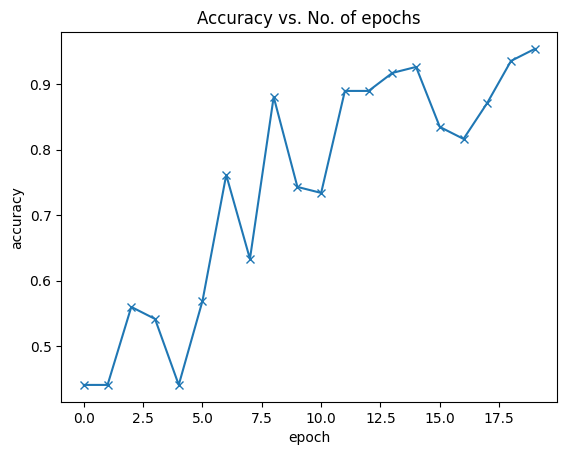

In [43]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)


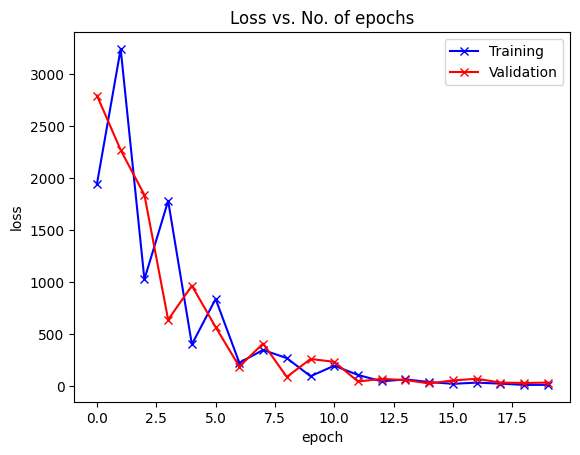

In [44]:

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [45]:
# Create a TensorDataset from the test data
# test_dataset = TensorDataset(X_test, y_test)

# Create a DataLoader from the test dataset
test_dl = DataLoader(test_subset, batch_size*2, num_workers=4, pin_memory=True)

# Evaluate the model on the test data
result = evaluate(model, test_dl)

# Print the test loss and accuracy
print("Test loss: {:.4f}, test accuracy: {:.4f}".format(result['val_loss'], result['val_acc']))

Test loss: 50.0307, test accuracy: 0.8455


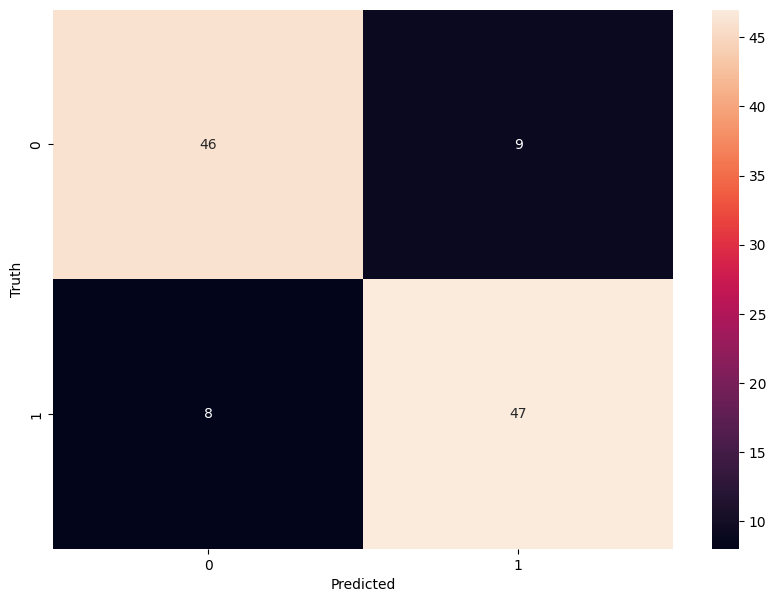

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a DataLoader from the test dataset
test_dl = DataLoader(test_subset, batch_size*2, num_workers=4, pin_memory=True)

# Get the true labels and the predicted labels
y_true = np.array([])
y_pred = np.array([])

model.eval()
with torch.no_grad():
    for images, labels in test_dl:
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        y_true = np.concatenate((y_true, labels.numpy()))
        y_pred = np.concatenate((y_pred, predicted.numpy()))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculate the Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall}")

Accuracy: 0.8454545454545455
Precision: 0.8455687830687831
Recall: 0.8454545454545455


In [48]:
print("There are the following classes in the training dataset:")
for idx, cls in enumerate(np.unique(classes)):
    clas_count = y_true[y_true == cls].shape[0]
    print(f"{cls}: {clas_count}")
# print("There are the following classes in the testing dataset:")
# for idx, cls in enumerate(np.unique(classes)):
#     clas_count = test_y[test_y == cls].shape[0]
#     print(f"{cls}: {clas_count}")

There are the following classes in the training dataset:
0: 55
1: 55


In [51]:
print(X_val.shape)
print(X_test.shape)

AttributeError: 'tuple' object has no attribute 'shape'